# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer( n_features=2 ** 16, alternate_sign=False, strip_accents='ascii', lowercase=True, ngram_range=(1,2))
        
        
        
        ## 3 changes. strip accents, lowercase, ngram_range,  ## stop_words='english',
        
        #CUT FROM ORIGINAL: 
        #n_features=2 ** 17, 
        ## n_features=2 ** 16
        ### ngram_range(1,3)
        
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
   
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")
   # toxic_data['case_count'] = toxic_data['comment_text'].str.split(' ').str.isupper()
    toxic_data['punc_count2'] = toxic_data['comment_text'].str.count("\!")
    toxic_data['punc_count3'] = toxic_data['comment_text'].str.count("\?")
    ####new columns here 
    toxic_data['upper_case'] = toxic_data['comment_text'].str.count(r'[A-Z]')
#     toxic_data['you_count'] = toxic_data['comment_text'].str.count("you")
    #toxic_data['fuck'] = toxic_data['comment_text'].str.count("fuck")
    #toxic_data['bitch'] = toxic_data['comment_text'].str.count("bitch")
    #toxic_data['shit'] = toxic_data['comment_text'].str.count("shit")


    X_quant_features = toxic_data[["word_count", "punc_count", "punc_count2", "upper_case"]]
    
    #####, "you_count" "fuck", "bitch", "shit"
    
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='C:/Users/Dallas/Desktop/Machine Learning/toxiccomments_train.csv', my_random_seed=85)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [5]:
# from sklearn import linear_model
# ols = linear_model.SGDClassifier(loss="squared_loss")
# ols.fit(X_train, y_train)

# ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
# ols_performance_train.compute_measures()
# print(ols_performance_train.performance_measures)

### MODEL: SVM, linear

In [6]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 12979, 'Neg': 114677, 'TP': 12944, 'TN': 114663, 'FP': 14, 'FN': 35, 'Accuracy': 0.9996161559190324, 'Precision': 0.9989195863559192, 'Recall': 0.9973033361584097, 'desc': 'svm_train'}


In [7]:
### MODEL: SVM, linearSVC

In [8]:
# class sklearn.svm.LinearSVC(penalty='l2', loss='squared_hinge', *, dual=True, tol=0.0001, 
#C=1.0, multi_class='ovr', fit_intercept=True, 
#intercept_scaling=1, class_weight=None, verbose=0, random_state=None, max_iter=1000)

#from sklearn.svm import LinearSVC
#svc = LinearSVC(C=.01, max_iter=100000)
#svc.fit(X_train, y_train)
#svc_performance_train = BinaryClassificationPerformance(svc.predict(X_train), y_train, 'svc_train-c=.0001')
#svc_performance_train.compute_measures()
#print(svc_performance_train.performance_measures)

### MODEL: logistic regression

In [9]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 12979, 'Neg': 114677, 'TP': 12961, 'TN': 114660, 'FP': 17, 'FN': 18, 'Accuracy': 0.9997258256564517, 'Precision': 0.9986900909231007, 'Recall': 0.9986131443100393, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [10]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB(alpha=.01)
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 12979, 'Neg': 114677, 'TP': 12150, 'TN': 106433, 'FP': 8244, 'FN': 829, 'Accuracy': 0.9289261765996114, 'Precision': 0.5957634598411298, 'Recall': 0.9361275907234764, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [11]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 12979, 'Neg': 114677, 'TP': 12957, 'TN': 114662, 'FP': 15, 'FN': 22, 'Accuracy': 0.9997101585511061, 'Precision': 0.9988436632747456, 'Recall': 0.9983049541567147, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [12]:
from sklearn import linear_model
#class sklearn.linear_model.RidgeClassifier(alpha=1.0, *, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, 
#tol=0.001, class_weight=None, solver='auto', random_state=None)

rdg = linear_model.RidgeClassifier(alpha=30,fit_intercept=True,normalize=True,copy_X=True, class_weight='balanced',solver='sag')
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

C:\Users\Dallas\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


{'Pos': 12979, 'Neg': 114677, 'TP': 12223, 'TN': 105338, 'FP': 9339, 'FN': 756, 'Accuracy': 0.9209202857680016, 'Precision': 0.5668769130878397, 'Recall': 0.9417520610216503, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [13]:
# from sklearn.ensemble import RandomForestClassifier
# rdf = RandomForestClassifier(max_depth=2, random_state=0)
# rdf.fit(X_train, y_train)

# rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
# rdf_performance_train.compute_measures()
# print(rdf_performance_train.performance_measures)

### ROC plot to compare performance of various models and fits

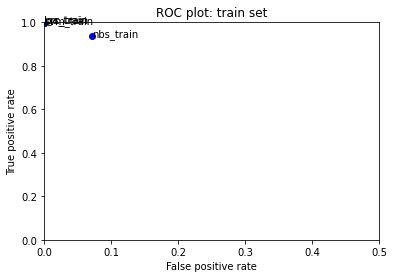

In [14]:
fits = [svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train]
#  rdg_performance_train,rdf_performance_train,svc_performance_train, 
for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, .5, 0, 1])
plt.title('ROC plot: train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [15]:
# ols_predictions = ols.predict(X_train)

In [16]:
# # false positives

# print("Examples of false positives:")

# import random, time

# for i in range(0, len(ols_predictions)):
#     if (ols_predictions[i] == 1):
#         if (X_raw_train.iloc[i]['any_toxic'] == 0):
#             if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
#                 print(i)
#                 print(X_raw_train.iloc[i]['comment_text'])
#                 print('* * * * * * * * * ')


In [17]:
nbs_predictions = nbs.predict(X_train)

In [18]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(nbs_predictions)):
    if (nbs_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')

Examples of false positives:
325
Lancashire
J3Mrs why have you deleted every thing ive just said to you
* * * * * * * * * 
723
I shall go ahead and do it.

86.146.153.231
* * * * * * * * * 
1351
Sure Thing!68.79.88.224
* * * * * * * * * 
1741
Yes.  Play the game, and you'll see that it is definitely a first person game.  The camera is in the tank, not behind it.
* * * * * * * * * 
1903
you take this way too seriously 

stay out of my life, and off of the page that is about me.
* * * * * * * * * 
2014
It now reads like a fan magazine. Cut down on the trivia please.
* * * * * * * * * 
2135
REDIRECT Talk:Peter Chiarelli (ice hockey)
* * * * * * * * * 
2153
IT WASNT ME I SWEAR THE DRUGS MADE ME DO IT WHY DID I HAVE TO AKES GODS WORK INTO MY OWN HANDS WHHHHHHHHHHHHHYYYYYYYYYYYYYYYYYYYYY
* * * * * * * * * 
2627
In which case why haven't you reported me?
* * * * * * * * * 
2813
Hi 

how do you become a adminstructor
* * * * * * * * * 
3718
You must have your anatomical book upside down, mate


19602
Okay, thank you for saying. All the best. (  )
* * * * * * * * * 
20160
, Bismuth nanotubes, Graphine
* * * * * * * * * 
20195
This edit looks ok.
* * * * * * * * * 
21202
hi 

hey could u plz get rid of 22 armdale?
* * * * * * * * * 
21868
your country 

are you american or a brit living in america because judging by your past edits you seem to be into a lot of britih music. User:Harry Weasley
* * * * * * * * * 
22751
(island)]] (later we'd better change title to Cyprus)
* * * * * * * * * 
24239
I never called you a

d.f.

Was some other user, maybe an old page.  

Actually, you seem reasonable sometimes.

Smile

Jeff.
* * * * * * * * * 
24802
Hey 

Hey man, or you a moderator, or editor or whatever?
* * * * * * * * * 
24998
Well I will use my user page then, don't tell meyour gonna remove it too, because that will piss me off and drive me nuts. Also I am not making a personal ttack on Jimmy wales, I am saying he is a bit to greedy dont you think? He's got 6 million dollars alre

50963
Sod off Retaker. Your lies aren't welcome here.
* * * * * * * * * 
50970
Hi 

Dear Sikhs,

I would request all you all to please help me in exposing Sikh Scholar, who actually is an RSS sponsered person pretending to be Sikh, please see below the kind of statements he makes to me

Wow wow so the truth is finaly out....you have spoken like a true Hindu RSS wala......is that the way a scholar speaks...wow...(my answere to him)

(Sikh Scholars comments to me)....... stupid dumb FU*K MY great great great great grandfather was Mani Singh the greatest of Sikh matrys. Its scum like you that needs to be executed. You deserve execution - you stupid dumb fu*k everyone in my family over 500 members are Baptized Khalsa SIKHS. We have been Khalsa Sikhs for over 300 years you dumb fu*ker. Because you have insulted me and broken the teachings of the Guru Granth Sahib you deserve death -you dumb fu*ker.Sikh scholar (talk) 

(my answere to him)...Now I will be after you to expose all your RSS gan

79707
why did you revert my comment.  thanks
* * * * * * * * * 
80254
why are you repeatedly warning me for the same incident? 

i have gotten three warnings for the same post.. why dont you chill out?  (is asking someone to chill out a personal attack?)

look how many arguments there are on this page.. and how many have been deleted out on top?  i am not interested.

(this is not an attack and feel free to delete this afterward)
* * * * * * * * * 
80636
read 100 pages a day or more.
* * * * * * * * * 
80652
Please Unblock Me Now!  

Sorry for what I've Done. I want this IP Address of mine to just change and when will that happen?
* * * * * * * * * 
81354
Well,it's high time you did. Thanks.
* * * * * * * * * 
81366
from the same person who reported me for harassment and abuse. He also lied when he said this went against talk page consensus and that my edit was not sourced
* * * * * * * * * 
82390
I 100% agree with you
* * * * * * * * * 
83074
Who's a celebrity then?
Congratulations, I

102674
They are a Jewish pro-Israel organization. Why bother to try to hide their identity?
* * * * * * * * * 
103059
What did you block me for?
I haven't done anything.
* * * * * * * * * 
103375
due to petty point scoring and lack of objectivity
* * * * * * * * * 
103972
Give me a break. I'm calling a pedophile a pedophile and you're saying there are no laws against it? I would suggest you do the same and make out with a 13-year old girl to test the law but that's revolting and hope that you don't and cannot fathom your defense of this. Yes, child molesters are pedophiles and those who are committing this crime are pedophiles. You're...I just don't have words for someone like you defending pedophiles on MY talk page. GTFO.
* * * * * * * * * 
104040
"

 A pie for you! 

  Here's a pie to make you feel better.   "
* * * * * * * * * 
104155
REDIRECT Talk:List of Married... with Children episodes
* * * * * * * * * 
104544
Whatever.  He never tried to explain that he is not an admin until 

116815
I love to talk to people and they like to talk to me

i love to skateboard and i do not have a myspace this

is the only thing i got.
* * * * * * * * * 
116965
"

 and Then i was Walking down the street in India and It Was Gandhi 

and He Was All 'i don't eat the Smoked Meats but Toddt he's So Gay"""
* * * * * * * * * 
117345
"

did you just call me ""stupid"". I cannot believe this. You block people for personal attacks and then you just come at them.  THis is totally relevant.   JohnHistory"
* * * * * * * * * 
117585
UNBLOCK ME ON .ES NOW!
* * * * * * * * * 
117981
Bot 

So any new disruptive bots in the works? BTW, you ought to archive your page. It's getting a little long there. 76.100.195.188
* * * * * * * * * 
118117
Eat my shorts 

Eat my shorts, Arsefacey.
* * * * * * * * * 
118209
Don't be so deceitful. Constructive edits are not vandalism. You know that full well. You have been reverting everything anyone adds without discussion and without good reason. THAT is obvious

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [19]:
# ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
# ols_performance_test.compute_measures()
# print(ols_performance_test.performance_measures)

### MODEL: SVM, linear

In [20]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3246, 'Neg': 28669, 'TP': 2020, 'TN': 27204, 'FP': 1465, 'FN': 1226, 'Accuracy': 0.9156822810590631, 'Precision': 0.5796269727403156, 'Recall': 0.6223043746149106, 'desc': 'svm_test'}


In [21]:
###SVC TEST 

#svc_performance_testc0_01 = BinaryClassificationPerformance(svc.predict(X_test), y_test, 'svc_test-c=.01')
#svc_performance_testc0_01.compute_measures()
#print(svc_performance_train.performance_measures)

### MODEL: logistic regression

In [22]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3246, 'Neg': 28669, 'TP': 1951, 'TN': 27434, 'FP': 1235, 'FN': 1295, 'Accuracy': 0.9207269309102303, 'Precision': 0.6123666038920276, 'Recall': 0.6010474430067776, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [23]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3246, 'Neg': 28669, 'TP': 2021, 'TN': 26266, 'FP': 2403, 'FN': 1225, 'Accuracy': 0.886323045589848, 'Precision': 0.4568264014466546, 'Recall': 0.6226124460874923, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [24]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3246, 'Neg': 28669, 'TP': 2039, 'TN': 27242, 'FP': 1427, 'FN': 1207, 'Accuracy': 0.9174682751057497, 'Precision': 0.5882862088863243, 'Recall': 0.6281577325939618, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [25]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3246, 'Neg': 28669, 'TP': 2712, 'TN': 26072, 'FP': 2597, 'FN': 534, 'Accuracy': 0.9018956603477989, 'Precision': 0.5108306649086457, 'Recall': 0.8354898336414048, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [26]:
# rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
# rdf_performance_test.compute_measures()
# print(rdf_performance_test.performance_measures)

### ROC plot to compare performance of various models and fits

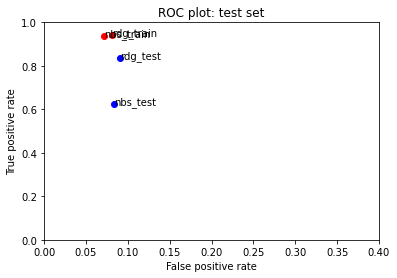

In [27]:
fits = [nbs_performance_train, rdg_performance_train]

#svc_performance_train, -- Discussion Week 3
#rdg_performance_train, rdf_performance_train, 
#,svc_performance_train
for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'ro')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
    


fits = [nbs_performance_test, rdg_performance_test]
#svc_performance_testc0_01
#svc_performance_testc0_0001  --  Discussion Week 3
#svm_performance_test, lgs_performance_test, , prc_performance_test, rdg_performance_test, rdf_performance_test, 
for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, .4, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [28]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='C:/Users/Dallas/Desktop/Machine Learning/toxiccomments_test.csv', my_random_seed=85, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 65536)
Look at a few rows of the new quantitative features: 
   word_count  punc_count  punc_count2  upper_case
0          72          10            0           4
1          13           1            0           7
2          16           0            0           4
3          38           3

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [29]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = rdg.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.2706445378809642


In [30]:
raw_data.head()

,id,comment_text,word_count,punc_count,punc_count2,punc_count3,upper_case
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10,0,0,4
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1,0,0,7
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0,0,0,4
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3,0,0,4
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1,0,0,1


In [31]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,False
2,00013b17ad220c46,False
3,00017563c3f7919a,False
4,00017695ad8997eb,False


In [32]:
my_submission.shape

(153164, 2)

In [33]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('C:/Users/Dallas/Desktop/Machine Learning/dataSubmission/toxiccomments_submission3.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation